In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import shapely
import pyproj
import math
from shapely.ops import transform, Point, Polygon, nearest_points
from shapely.geometry import mapping

## original dataset value transformation

In [3]:
# read data and transform to wgs84

nyc_gdf = gpd.read_file('dataframes/nycsquirrels_clean_1.csv')
nyc_gdf = gpd.GeoDataFrame(nyc_gdf, geometry=gpd.points_from_xy(nyc_gdf.long, nyc_gdf.lat))
nyc_gdf1 = nyc_gdf.set_crs('epsg:4326')

# convert fake bools (string) into 0s and 1s

behaviors = ['approaches', 'indifferent', 'runs_from', 
             'running', 'chasing', 'climbing', 'eating', 'foraging',
             'kuks', 'quaas', 'moans', 'tail_flags', 'tail_twitches']

bool_to_int = lambda x: 1 if x == 'TRUE' else 0

behavior_to_int = pd.DataFrame({behavior: nyc_gdf1[behavior].apply(bool_to_int) for behavior in behaviors})
nyc_gdf1.update(behavior_to_int)

# convert fake floats (string) to floats

long_float = nyc_gdf1['long'].apply(lambda x: float(x))
lat_float = nyc_gdf['lat'].apply(lambda x: float(x))

nyc_gdf1 = nyc_gdf1.assign(long = nyc_gdf1['long'].apply(lambda x: float(x)), 
                           lat = nyc_gdf['lat'].apply(lambda x: float(x)))
# nyc_gdf1.explore()

## add osm data

In [4]:
### load geojson datasets

centralpark_water_osm = gpd.read_file('geojson/water_cp.geojson')
centralpark_stream_osm = gpd.read_file('geojson/streams_cp.geojson')
centralpark_playg_osm = gpd.read_file('geojson/playgrounds_cp.geojson')
centralpark_paved_osm = gpd.read_file('geojson/paved.geojson')
centralpark_toilets_osm = gpd.read_file('geojson/toilets.geojson')
cp_northbd_osm = gpd.read_file('geojson/northbd.geojson') # cp north
cp_jorbd_osm = gpd.read_file('geojson/jorbd.geojson') # jacqueline kennedy onassis reservoir
cp_greatlawnbd_osm = gpd.read_file('geojson/greatlawnbd.geojson') # great lawn
cp_ramblebd_osm = gpd.read_file('geojson/ramblebd.geojson') # ramble
cp_southbd_osm = gpd.read_file('geojson/southbd.geojson') # cp south
met_osm = gpd.read_file('geojson/met.geojson') # the met
centralpark_gardens_osm = gpd.read_file('geojson/gardens_cp.geojson')
allwoodsosm = gpd.read_file('geojson/woods_cp.geojson').assign(feature_type = 'woods')
cp_baseball_osm = gpd.read_file('geojson/baseballpitch.geojson')
cp_field_osm = gpd.read_file('geojson/field.geojson')
allbarerockosm = gpd.read_file('geojson/bare_rock.geojson').assign(feature_type = 'bare_rock')
cp_pedestrian_osm = gpd.read_file('geojson/pedestrian.geojson')
cp_sportscenter_osm = gpd.read_file('geojson/sportscenter.geojson')

In [5]:
### data cleaning

drop_water_osm = ['relation/2389611', 'relation/2389521', 'relation/2389581', 
                  'relation/2389563','relation/2212963', 'way/608955193', 
                  'way/375673047', 'way/375673046', 'way/1024586392',
                  'way/727185210', 'way/727185216', 'way/727185221', 'way/727185214', 
                  'way/113690622', 'way/163470962', 'way/260910559', 'way/319615314', 
                  'way/319615316', 'way/394395237', 'way/394395238', 'way/470714268', 
                  'way/988718514', 'way/958630356']

drop_water_index = [centralpark_water_osm[centralpark_water_osm.get('id') == 
                                          water_id].index[0] 
                    for water_id in drop_water_osm]

cp_water_osm = centralpark_water_osm.drop(index=drop_water_index)

allwaterosm = pd.concat([cp_water_osm, centralpark_stream_osm])
allwaterosm = allwaterosm.reset_index().drop(columns = 'index')
water_feature_type = allwaterosm['natural'].fillna(allwaterosm['waterway'])
allwaterosm = allwaterosm.assign(feature_type = water_feature_type)


centralpark_playg_osm.at[23, 'name'] = 'Rudin Family Playground'
centralpark_playg_osm.at[50, 'name'] = 'Safari Playground'

cp_playgrounds_name = ['West 110th Street Playground', 'Tarr Family Playground', 
                       'Rudin Family Playground','Robert Bendheim Playground', 
                       'Tarr-Coyne Wild West Playground', '96th Street Playground', 
                       'Abraham and Joseph Spector Playground', 
                       'Arthur Ross Pinetum Playground', 
                       'Diana Ross Playground', 'Ancient Playground', 'Safari Playground',
                       'Ruth and Arthur Smadbeck-Heckscher East Playground', 
                       'Adventure Playground', 'Tarr-Coyne Tots Playground', 
                       'East 72nd Street Playground', 'Billy Johnson Playground', 
                       'Hecksher Playground', 'Mariner\'s Playground']

cp_playgrounds_index = [centralpark_playg_osm[centralpark_playg_osm.get('name') == 
                                              playground_name].index[0]
                        for playground_name in cp_playgrounds_name]

allplaygosm = centralpark_playg_osm.loc[cp_playgrounds_index].assign(feature_type = 'playground')


drop_paved_name = ['Park Avenue', 'Madison Avenue', 'Lexington Avenue', 
                   'York Avenue', 'FDR Drive', 
                   'Riverside Drive', 'West End Avenue', 
                   'Frederick Douglass Boulevard', 'Malcolm X Boulevard',
                   '8th Avenue', '7th Avenue', '6th Avenue', 
                   'East 106th Street', 'East 97th Street', 'East 96th Street', 
                   'East 86th Street', 'East 85th Street', 'East 84th Street', 
                   'East 79th Street',
                   'East 72nd Street', 'East 66th Street', 'East 65th Street',
                   'East 60th Street', 'East 59th Street',
                   'East 73rd Street', 'East 71st Street', 'East 61st Street',
                   'Cathedral Parkway', 'West 110th Street', 'West 106th Street', 
                   'West 96th Street', 
                   'West 95th Street', 'West 86th Street', 'West 81st Street', 
                   'West 79th Street', 
                   'West 75th Street', 'West 72nd Street', 'West 66th Street', 
                   'West 65th Street',
                   'West 62nd Street', 'West 54th Street', 'West 53rd Street']

drop_paved_index = []

for name in drop_paved_name:
    index_list = centralpark_paved_osm[centralpark_paved_osm.get('name') == name].index
    for index in index_list:
        drop_paved_index.append(index)
        
drop_5th_ends = ['way/988984235', 'way/195743336', 'way/422298615', 
                 'way/962626218', 'way/198924778',
                 'way/840996403', 'way/980855831', 'way/980855832', 
                 'way/980855833', 'way/22898583',
                 'way/46613661', 'way/5670874', 'way/167922075', 
                 'way/584850094', 'way/834058007', 'way/5673363', 'way/584850099']

for way in drop_5th_ends:
    drop_paved_index.append(centralpark_paved_osm[centralpark_paved_osm.get('id') == 
                                                  way].index[0])
    

allpavedosm = centralpark_paved_osm.drop(index = drop_paved_index).assign(feature_type = 'paved')



drop_toilets = ['node/2329911645', 'node/8539548031', 'node/1310874079', 
                'node/2339622631', 'way/266919662', 'way/668189108']

drop_toilets_index = [centralpark_toilets_osm[centralpark_toilets_osm.get('id') == 
                                              node].index[0]
                      for node in drop_toilets]

alltoiletsosm = centralpark_toilets_osm.drop(index = drop_toilets_index).assign(feature_type = 'toilet')



keepbd_columns = ['id', 'alt_name', 'amenity', 'building', 'height', 'name', 'geometry']

cp_northbd_id = ['way/39243913', 'way/278366155', 'way/278366170', 'way/118729389', 
                 'way/943419152',
                 'way/278366166', 'way/278366163', 'way/278366174']
cp_northbd_index = [cp_northbd_osm[cp_northbd_osm.get('id') == northbd_id].index[0] 
                    for northbd_id in cp_northbd_id]
allnorthbdosm = cp_northbd_osm.loc[cp_northbd_index].get(keepbd_columns)

cp_jorbd_id = ['way/278363031', 'way/817397167', 'way/278363044']
cp_jorbd_index = [cp_jorbd_osm[cp_jorbd_osm.get('id') == jorbd_id].index[0] 
                  for jorbd_id in cp_jorbd_id]
alljorbdosm = cp_jorbd_osm.loc[cp_jorbd_index].get(keepbd_columns)

cp_greatlawnbd_id = ['way/278363039', 'way/278363038', 'way/278363033', 
                     'way/278363041', 'way/278363029',
                     'way/278363036', 'way/278363065', 'way/278363049', 
                     'way/278363046', 'way/278363024', 
                     'way/278363048', 'way/278363035', 'way/278363053']
cp_greatlawnbd_index = [cp_greatlawnbd_osm[cp_greatlawnbd_osm.get('id') == 
                                           greatlawnbd_id].index[0] 
                        for greatlawnbd_id in cp_greatlawnbd_id]
allgreatlawnbdosm = cp_greatlawnbd_osm.loc[cp_greatlawnbd_index].get(keepbd_columns)

cp_ramblebd_id = ['way/278361406', 'way/278361407', 'way/775820359', 'relation/3698871', 
                  'way/354587581', 'way/354587583', 'way/265347581', 'way/265347585', 
                  'way/362647331', 'way/265347579', 'way/265347587']
cp_ramblebd_index = [cp_ramblebd_osm[cp_ramblebd_osm.get('id') == ramblebd_id].index[0] 
                     for ramblebd_id in cp_ramblebd_id]
allramblebdosm = cp_ramblebd_osm.loc[cp_ramblebd_index].get(keepbd_columns)

cp_southbd_id = ['way/265347589', 'way/585788256', 'way/265347597', 
                 'way/265347588', 'way/265347593',
                 'way/321166650', 'way/321166649', 'way/265347596', 
                 'way/265347590', 'way/265347591',
                 'way/385442739', 'way/265347586', 'way/265347592']
cp_southbd_index = [cp_southbd_osm[cp_southbd_osm.get('id') == southbd_id].index[0] 
                    for southbd_id in cp_southbd_id]
allsouthbdosm = cp_southbd_osm.loc[cp_southbd_index].get(keepbd_columns)

allmetosm = met_osm[met_osm.get('name') == 'The Metropolitan Museum of Art']

allbuildingosm = pd.concat([allnorthbdosm, alljorbdosm, allgreatlawnbdosm, 
                            allramblebdosm, allsouthbdosm, allmetosm]).assign(feature_type = 'building')


drop_garden = ['way/362826846', 'way/169915675', 'way/330448922', 
               'way/313994014', 'way/202503285',
               'way/225189389', 'way/796333282', 'way/225188744']

drop_garden_index = [centralpark_gardens_osm[centralpark_gardens_osm.get('id') == 
                                             way].index[0] 
                     for way in drop_garden]
    
allgardenosm = centralpark_gardens_osm.drop(index = drop_garden_index).assign(feature_type = 'garden')



drop_baseball = ['way/667343443', 'way/920569850', 'way/920569847', 'way/319797239']

drop_baseball_index = [cp_baseball_osm[cp_baseball_osm.get('id')
                                       == way].index[0] for way in drop_baseball]

allbaseballosm = cp_baseball_osm.drop(index = drop_baseball_index).assign(feature_type = 'pitch: baseball')


drop_field = ['way/188692199', 'way/951525207', 'way/951525216', 'way/951525219', 
              'way/951539223', 'way/951539207', 'way/951539204', 'way/951539221', 
              'way/951539203', 'way/951539215',
              'way/951539218', 'way/951525211', 'way/951539232', 'way/951525215', 
              'way/951525217',
              'way/951539196', 'way/951525222', 'way/951525209', 'way/972597724',
              'way/949457222', 'way/949457226', 'way/953189819', 'way/849307005', 
              'way/849307011', 'way/849307012',
              'way/849307006', 'way/952333244', 'way/849307009', 'way/953189823', 
              'way/952333240', 'way/949532332',
              'way/949848463', 'way/949851336', 'way/667981482', 'way/949848467', 
              'way/949848466',
              'way/833371440', 'way/949848471', 'way/949848459', 'way/949848457',
              'way/849046450', 'way/849046418', 'way/849046432', 'way/849046434', 
              'way/849046451',
              'way/849046431', 'way/849046424', 'way/849046433', 'way/849046423', 
              'way/667981479', 'way/667981483',
              'way/667981480', 'way/849046437', 'way/849046453', 'way/849046448', 
              'way/849046420',
              'way/849046440', 'way/849046435', 'way/849046417', 'way/849299252', 
              'way/849299251', 'way/949848465',
              'way/849046452', 'way/849046454', 'way/849046415', 'way/667981478', 
              'way/849046438', 'way/849046427',
              'way/849046421', 'way/849046429', 'way/849046457', 'way/849046428',
              'way/849046444', 'way/849046441', 'way/849046426', 'way/849046414', 
              'way/949848462']

drop_field_index = [cp_field_osm[cp_field_osm.get('id') == way].index[0] 
                    for way in drop_field]

allgrassosm = cp_field_osm.drop(index = drop_field_index).assign(feature_type = 'grass')


drop_ped = ['relation/4623434', 'relation/4623433', 'relation/4623431', 
            'way/1031859264', 'way/321166645',
            'relation/2280942', 'way/329988122', 'way/329988123', 
            'way/458452177', 'way/710571385', 
            'way/375314249', 'way/338043682', 'way/46340036', 'way/710571377', 'way/5671777']

drop_ped_index = [cp_pedestrian_osm[cp_pedestrian_osm.get('id') == ped].index[0] 
                  for ped in drop_ped]

allpedestrianosm = cp_pedestrian_osm.drop(index=drop_ped_index).assign(feature_type = 'pedestrian')


drop_spcenter = ['node/368062558', 'node/2724236668', 'node/5607297102']

drop_spcenter_index = [cp_sportscenter_osm[cp_sportscenter_osm.get('id') 
                                           == spcenter].index[0] 
                       for spcenter in drop_spcenter]

allspcenterosm = cp_sportscenter_osm.drop(index=drop_spcenter_index).assign(feature_type = 'sports center')

## `centralparkallfeaturesmap` : map all features with legend and tag

In [6]:
dataframes = [allbuildingosm, allgardenosm, allgrassosm, allpedestrianosm, allwaterosm, allwoodsosm,
              allpavedosm, allbaseballosm, allplaygosm, allspcenterosm, allbarerockosm, alltoiletsosm]

cp_allfeatures = pd.concat(dataframes)
cp_allfeatures = (cp_allfeatures
                  [np.array(
                            [not isinstance(geom_object, shapely.geometry.point.Point) 
                             for geom_object in cp_allfeatures.geometry])]
                  )[['id', 'geometry', 'name', 'feature_type']].reset_index().drop(columns = 'index')

relev_features = ['building', 'garden', 'grass', 'pedestrian', 'water', 'woods']

cp_allfeatures.replace({'feature_type': 'stream'}, 'water', inplace=True)
cp_features = cp_allfeatures.query('feature_type in @relev_features')

In [7]:
cp_allfeatures.to_csv('dataframes/cp_allfeatures.csv')
cp_features.to_csv('dataframes/cp_features.csv')

In [8]:
cp_allfeatures

id                                           geometry  \
0     way/39243913  POLYGON ((-73.95635 40.79872, -73.95635 40.798...   
1    way/278366155  POLYGON ((-73.95138 40.79711, -73.95136 40.797...   
2    way/278366170  POLYGON ((-73.95909 40.79729, -73.95902 40.797...   
3    way/118729389  POLYGON ((-73.95524 40.79639, -73.95523 40.796...   
4    way/943419152  POLYGON ((-73.95141 40.79469, -73.95135 40.794...   
..             ...                                                ...   
391  way/265347592  POLYGON ((-73.98071 40.76920, -73.98083 40.769...   
392  way/278363046  POLYGON ((-73.96914 40.78033, -73.96904 40.780...   
393  way/278366163  POLYGON ((-73.95312 40.79380, -73.95319 40.793...   
394  way/278366166  POLYGON ((-73.95277 40.79428, -73.95284 40.794...   
395  way/278366170  POLYGON ((-73.95909 40.79729, -73.95902 40.797...   

                      name feature_type  
0           The Blockhouse     building  
1    Dana Discovery Center     building  
2                     None     building  
3                     None     building  
4                     None     building  
..                     ...          ...  
391                   None       toilet  
392                   None       toilet  
393                   None       toilet  
394                   None       toilet  
395                   None       toilet  

[396 rows x 4 columns]

In [9]:
cp_allfeaturesmap = folium.Map(location = [40.7823, -73.96600], 
                                       zoom_start = 14, 
                                       min_zoom = 14,
                                       tiles = 'cartodbpositron', 
                                       control_scale = True)

def to_geojson_map(df, feature, folium_map, color_var, fillOp):
    gen_stylefunc = lambda x: {'color': color_var, 'fillOpacity': fillOp}
    to_geojson = folium.GeoJson(df[df['feature_type'] == feature], name=feature, style_function=gen_stylefunc)
    to_geojson.add_to(folium_map)
    return

allfeatures = list(cp_allfeatures['feature_type'].unique())
allcolors = {'building': '#ad6f03', 
             'garden': '#ff8cec', 
             'grass': '#86b35d', 
             'pedestrian': '#000000', 
             'water': '#1795e8', 
             'stream': '#1795e8', 
             'woods': '#098f57', 
             'paved': '#000000', 
             'pitch: baseball': '#e0cdb4', 
             'playground': '#f5931b', 
             'sports center': '#960000', 
             'bare_rock': '#525252', 
             'toilet': '#103b91'}

for i in range(len(allfeatures)):
    to_geojson_map(cp_allfeatures, allfeatures[i], cp_allfeaturesmap, allcolors[allfeatures[i]], 0.6)

folium.LayerControl().add_to(cp_allfeaturesmap)
cp_allfeaturesmap

In [10]:
cp_featuresmap = folium.Map(location = [40.7823, -73.96600], 
                    zoom_start = 14, 
                    min_zoom = 14,
                    tiles = 'cartodbpositron', 
                    control_scale = True)

for i in range(len(relev_features)):
    to_geojson_map(cp_features, relev_features[i], cp_featuresmap, allcolors[relev_features[i]], 0.6)

folium.LayerControl().add_to(cp_featuresmap)
cp_featuresmap

## buffers - squirrels *near* feature

In [11]:
# remove squirrels outside central park

centralpark_perimeter = allpavedosm[(allpavedosm.get('name') == '5th Avenue') |
                                    (allpavedosm.get('name') == 'Central Park North') |
                                    (allpavedosm.get('name') == 'Central Park West') |
                                    (allpavedosm.get('name') == 'Central Park South') |
                                    (allpavedosm.get('name') == 'Grand Army Plaza') |
                                    (allpavedosm.get('name') == 'Doris C. Freedman Place') |
                                    (allpavedosm.get('name') == 'Duke Ellington Circle')]

centralparkperimeter = centralpark_perimeter.unary_union.convex_hull

squirrelinside = nyc_gdf1.within(centralparkperimeter)
nyc_gdf1 = nyc_gdf1.assign(inside = squirrelinside)
nyc_gdf1 = nyc_gdf1[nyc_gdf1.get('inside') == True]

<AxesSubplot:ylabel='Frequency'>

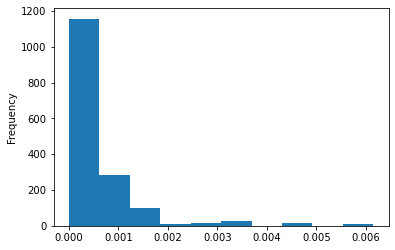

In [12]:
# area of each polygon 
planar_cpf = cp_features.to_crs('epsg:2263')
planar_cpf['area'] = planar_cpf.geometry.area
planar_cpf['inverse'] = planar_cpf['area'].apply(lambda x: 1/x if x != 0 else 0)
planar_cpf['inverse'].plot.hist(density=True)

In [13]:
# map and make dataframe


def calculate_buffer_radius(area, factor, cap, base):
    # buffer_counter[0] = factor
    if area == 0:
        return base
    math_func = math.pow(area, 0.4) * factor
    if math_func > cap:
        return cap
    return math_func


def to_featuregroup_map(df, feature, folium_map, color_var, fillOp):
    gen_stylefunc = lambda x: {'color': color_var, 'fillOpacity': fillOp}
    to_geojson = folium.GeoJson(df[df['feature_type'] == feature], name=feature, style_function=gen_stylefunc)
    to_featuregroup = folium.FeatureGroup(name=feature)
    to_geojson.add_to(to_featuregroup)
    to_featuregroup.add_to(folium_map)
    return


test_map = folium.Map(location = [40.7823, -73.96600], 
                          zoom_start = 14, 
                          min_zoom = 14,
                          tiles = 'cartodbpositron', 
                          control_scale = True)


buffercrs = pyproj.CRS('epsg:2263')
regcrs = pyproj.CRS('epsg:4326')
project = pyproj.Transformer.from_crs(buffercrs, regcrs, always_xy=True).transform

planar_nyc_gdf1 = nyc_gdf1.to_crs('epsg:2263')

geospatial_analysis = ['nearbuilding', 'neargarden', 'neargrass', 'nearpedestrian', 'nearwater', 'nearwoods']

# for i in range(1, 40, 1):
    # factor = i/10
    # buffer_counter = [0]
    
planar_cpf['buffer_radius'] = planar_cpf['area'].apply(calculate_buffer_radius, factor=1.2, cap=150, base=50)
    
for i in range(len(relev_features)):
    temp = planar_cpf[planar_cpf['feature_type'] == relev_features[i]].reset_index()
    temp_array = np.array([])
    
    for j in range(len(temp)):
        temp_array = np.append(temp_array, temp.geometry[j].buffer(temp['buffer_radius'][j]))
    
    temp_gpd = gpd.GeoDataFrame(geometry=temp_array)
    temp_planar_buffer = temp_gpd.geometry.unary_union
    nyc_gdf1[geospatial_analysis[i]] = planar_nyc_gdf1.within(temp_planar_buffer)
    temp_buffer = transform(project, temp_planar_buffer)
    
    temp_color = allcolors[relev_features[i]]
    gen_style_func = lambda x: {'color': 'b', 'fillOpacity': 0.2}
    temp_geojson = folium.GeoJson(temp_buffer, 
                                  name = relev_features[i] + ' buffer',
                                  style_function=gen_style_func).add_to(test_map)
    
for i in range(len(relev_features)):
    to_featuregroup_map(planar_cpf, relev_features[i], test_map, allcolors[relev_features[i]], 0.6)

folium.LayerControl().add_to(test_map)

buffered_nyc_df = nyc_gdf1[['long', 'lat', 'geometry'] + behaviors + geospatial_analysis].to_crs('epsg:4326')

all_squirrels = folium.FeatureGroup('all squirrels')

bfsqrls = buffered_nyc_df.query('nearbuilding == True or neargarden == True or neargrass == True or ' + 
                                'nearpedestrian == True or nearwater == True or nearwoods == True').reset_index().drop(columns='index')
for i in range(len(bfsqrls)):
    if bfsqrls.iloc[i]['nearwater'] == True or bfsqrls.iloc[i]['nearwoods'] == True:
        if bfsqrls.iloc[i]['indifferent']:
            sqrl_color = '#e3bb07'
        else:
            sqrl_color = '#453a36'
        folium.Circle(location=[bfsqrls.iloc[i]['lat'], bfsqrls.iloc[i]['long']],
                      color=sqrl_color, radius=2).add_to(test_map)
    
test_map

In [14]:
planar_cpf

id                                           geometry  \
0     way/39243913  POLYGON ((996335.970 230273.735, 996335.987 23...   
1    way/278366155  POLYGON ((997712.232 229689.634, 997716.595 22...   
2    way/278366170  POLYGON ((995577.254 229755.321, 995597.242 22...   
3    way/118729389  POLYGON ((996643.592 229425.102, 996645.404 22...   
4    way/943419152  POLYGON ((997704.554 228806.301, 997719.594 22...   
..             ...                                                ...   
172  way/386482336  POLYGON ((997464.556 228690.712, 997451.473 22...   
173  way/386482338  POLYGON ((997603.313 228725.400, 997605.695 22...   
174  way/386482340  POLYGON ((997282.762 228462.977, 997269.042 22...   
175  way/387382854  POLYGON ((996490.150 229304.684, 996194.900 22...   
176  way/430633035  POLYGON ((997594.360 228742.263, 997597.514 22...   

                      name feature_type           area   inverse  \
0           The Blockhouse     building    1103.375158  0.000906   
1    Dana Discovery Center     building    3877.393835  0.000258   
2                     None     building     429.231598  0.002330   
3                     None     building   12006.964830  0.000083   
4                     None     building     354.731725  0.002819   
..                     ...          ...            ...       ...   
172                   None        woods   20964.548676  0.000048   
173                   None        woods    2050.711383  0.000488   
174                   None        woods    6675.706123  0.000150   
175             The Ravine        woods  783295.898571  0.000001   
176                   None        woods    2106.877737  0.000475   

     buffer_radius  
0        19.782015  
1        32.703724  
2        13.559945  
3        51.398985  
4        12.564386  
..             ...  
172      64.235551  
173      25.347963  
174      40.642473  
175     150.000000  
176      25.623413  

[177 rows x 7 columns]

In [15]:
bfsqrls = buffered_nyc_df.query('nearbuilding == True or neargarden == True or neargrass == True or ' + 
                                'nearpedestrian == True or nearwater == True or nearwoods == True').reset_index().drop(columns='index')
for i in range(len(bfsqrls)):
    if bfsqrls.iloc[i]['nearwater'] == True or bfsqrls.iloc[i]['nearwoods'] == True:
        if bfsqrls.iloc[i]['indifferent']:
            sqrl_color = '#e3bb07'
        else:
            sqrl_color = '#453a36'
        folium.Circle(location=[bfsqrls.iloc[i]['lat'], bfsqrls.iloc[i]['long']],
                      color=sqrl_color, radius=2).add_to(test_map)
    
test_map

In [16]:
all_points = folium.FeatureGroup('all squirrels')



cp_featuresmap

In [17]:
bfsqrls = bfsqrls.drop(columns=['long', 'lat', 'geometry'])
bfsqrls.to_csv('dataframes/bfsqrls.csv')

# k nearest neighbor, k = 5